In [2]:
#loading data 
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/data.csv',error_bad_lines=False, engine="python")
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#getting unique datatypes
data["type"].value_counts()


INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [4]:
#preprocessing target data
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data


,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,1,0,0,0
8671,ENFP,'So...if this thread already exists someplace ...,0,1,0,0
8672,INTP,'So many questions when i do these things. I ...,1,1,1,0
8673,INFP,'I am very conflicted right now when it comes ...,1,1,0,0


In [5]:
#importing necessary libraries
from nltk import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
lemmatiser = WordNetLemmatizer()
useless_words = stopwords.words("english")
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
#one hot encoding for target variable
import numpy as np
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    return [b_Pers[l] for l in personality]
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s
list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [7]:
#text / feature preprocessing ie; removing stop words,urls etc
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      posts = row[1].posts
      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)
      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()
      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)
      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")
      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type)
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)
  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [8]:
np.unique(data["type"]).size
print(list_personality)
print("****************")
print(list_personality_bin)


[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]
****************
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import  train_test_split

In [10]:
list_posts

array(['   moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello  sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo  lady complimentary personality

In [11]:
#spliting data for train and test
x_train,x_test,y_train,y_test=train_test_split(list_posts,list_personality_bin,stratify=list_personality_bin,train_size=0.8)

In [12]:
print(x_train.size)
print(x_test.size)
print("*************")
print(y_train.size)
print(y_test.size)

6940
1735
*************
27760
6940


In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 22.5 MB/s 
     |████████████████████████████████| 6.6 MB 61.2 MB/s 
     |████████████████████████████████| 120 kB 70.6 MB/s 


In [14]:
#texting preprocessing in bert model
from transformers import TFBertModel, BertTokenizer
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [15]:
X_train = prepare_bert_input(x_train, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(x_test, MAX_SEQ_LEN, BERT_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
#building model
import torch
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]
bert = TFBertModel.from_pretrained(BERT_NAME,from_pt=True)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

In [17]:
!pip install tensorflow_addons
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint


In [19]:
#detecting gpu 
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
#compiling model
max_epochs = 15
batch_size = 16
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)
#model.save('/content/models/model.h5')
model.save_weights('/content/models/weights.h5')

Epoch 1/15


434/434 - 227s - loss: 0.5697 - auc: 0.5649 - binary_accuracy: 0.7068 - 227s/epoch - 524ms/step
Epoch 2/15


434/434 - 203s - loss: 0.5429 - auc: 0.6445 - binary_accuracy: 0.7287 - 203s/epoch - 467ms/step
Epoch 3/15


434/434 - 203s - loss: 0.5144 - auc: 0.7031 - binary_accuracy: 0.7490 - 203s/epoch - 468ms/step
Epoch 4/15


434/434 - 203s - loss: 0.4654 - auc: 0.7733 - binary_accuracy: 0.7763 - 203s/epoch - 468ms/step
Epoch 5/15


434/434 - 203s - loss: 0.3683 - auc: 0.8684 - binary_accuracy: 0.8332 - 203s/epoch - 468ms/step
Epoch 6/15


434/434 - 203s - loss: 0.2525 - auc: 0.9410 - binary_accuracy: 0.8914 - 203s/epoch - 467ms/step
Epoch 7/15


434/434 - 202s - loss: 0.1550 - auc: 0.9786 - binary_accuracy: 0.9374 - 202s/epoch - 467ms/step
Epoch 8/15


434/434 - 203s - loss: 0.0994 - auc: 0.9916 - binary_accuracy: 0.9606 - 203s/epoch - 467ms/step
Epoch 9/15


434/434 - 202s - loss: 0.0767 - auc: 0.9950 - binary_accuracy: 0.9707 - 202s/epoch - 466ms/step
Epoch 10/15


434/434 - 203s - loss: 0.0573 - auc: 0.9970 - binary_accuracy: 0.9783 - 203s/epoch - 469ms/step
Epoch 11/15


434/434 - 203s - loss: 0.0429 - auc: 0.9981 - binary_accuracy: 0.9846 - 203s/epoch - 467ms/step
Epoch 12/15


434/434 - 204s - loss: 0.0440 - auc: 0.9983 - binary_accuracy: 0.9838 - 204s/epoch - 470ms/step
Epoch 13/15


434/434 - 203s - loss: 0.0382 - auc: 0.9986 - binary_accuracy: 0.9861 - 203s/epoch - 468ms/step
Epoch 14/15


434/434 - 202s - loss: 0.0363 - auc: 0.9987 - binary_accuracy: 0.9865 - 202s/epoch - 466ms/step
Epoch 15/15


434/434 - 202s - loss: 0.0368 - auc: 0.9984 - binary_accuracy: 0.9863 - 202s/epoch - 466ms/step


In [21]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = '/content/models/weights.h5'
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=40)

44/44 [==============================] - 21s 334ms/step - loss: 1.5865 - auc_1: 0.6330 - binary_accuracy: 0.6934


[1.5865113735198975, 0.6330341100692749, 0.6933717727661133]

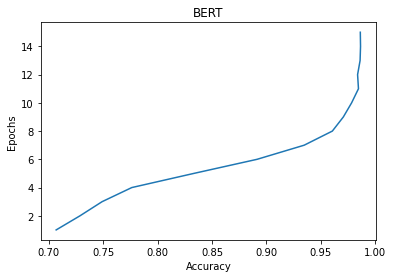

In [23]:
a=[0.7068,0.7287,0.7490,0.7763,0.8332,0.8914,0.9347,0.9606,0.9707,0.9783,0.9846,0.9838,0.9861,0.9865,0.9863]
b=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
import matplotlib.pyplot as plt
plt.plot(a,b)
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.title("BERT")
plt.show()

In [41]:
#prediction
axes = ["I-E","N-S","T-F","J-P"]
s1="A fascinating list that shows how entrepreneurs are flexible & ‘pivot’ when opportunity arises. But it provides a great lesson even for our personal lives: Don’t be afraid of change. You don’t have to stay wedded to what you originally started out to do. Evolution is life"
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))
    b=str(pred_axis)
    print("\n")
    dic={"['I', 'S', 'T', 'J']":"Hardworking and Trustworthy","['I', 'S', 'F', 'J']":"Responsible and Devoted Caretakers","['I', 'N', 'F', 'J']":"Organized and Insightful","['I', 'N', 'T', 'J']":"Innovative,Strategic and Independent","['I', 'S', 'T', 'P']":"Action,logical oriented and Spontaneous","['I', 'S', 'F', 'P']":"Gentle,Nurturing and Sensitive","['I', 'N', 'F', 'P']":"Creative,Idealistic and Loyal","['I', 'N', 'T', 'P']":"Intellectual,Precise and Imaginative","['E', 'S', 'T', 'P']":"Action Oriented and Skillfull negotiators","['E', 'S', 'F', 'P']":"Helpful,Spontaneous and Strong common sense","['E', 'N', 'F', 'P']":"Supportive and Value inspiration","['E', 'N', 'T', 'P']":"Strategic and Inventive","['E', 'S', 'T', 'J']":"Realistic and Dependable","['E', 'S', 'F', 'J']":"Conscientious and Pratical oriented","['E', 'N', 'F', 'J']":"Skilled Communicator,Caring and Idealistic","['E', 'N', 'T', 'J']":"Strategic and long range planners"}
    for i,j in dic.items():
      if(b==i):
        print("Personality is: ",j)

-- comment: A fascinating list that shows how entrepreneurs are flexible & ‘pivot’ when opportunity arises. But it provides a great lesson even for our personal lives: Don’t be afraid of change. You don’t have to stay wedded to what you originally started out to do. Evolution is life
-- personality: ['E', 'N', 'F', 'J']
-- scores:[9.7446334e-01 3.4945118e-05 9.7951674e-01 4.6276513e-01]


Personality is:  Skilled Communicator,Caring and Idealistic
